# import modules and define global parameters

In [3]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import tensorly as tl
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

num_test = 234*2*39
num_drug_a = 38
num_drug_b = 38
num_cell_line = 39
num_compo = 1000
num_predict = 240 * num_cell_line
methods = ['dnn','cpwopt','log','rf']


Using TensorFlow backend.


# stratify sampling generate data for 100 experiments ( the results are output and saved )

In [ ]:
# original_index = np.arange(38*38).reshape(38,38)
# to_operate = []
# for i in range(37):
#     to_operate = to_operate + list(original_index[i,i+1:])
    
# to_delete = []
# miss = list(nan_set[0])
# miss.sort()
# for i in range(16):
#     for j in range(i+1,16):
#         to_delete.append(miss[i]*38 + miss[j])
# for i in range(120):
#     to_operate.remove(to_delete[i])

# import random
# for k in range(100):
#     for i in range(39):
#         to_save = pd.DataFrame(random.sample(to_operate,234))
#         to_save_name = '/Users/apple/Desktop/uofm_tensor_Pro/data/test_pair'+str(k+1)+'/'+'tensor'+ str(i+1)+'.csv'
#         to_save.to_csv(to_save_name)

#

# read data preprocessed by R

In [4]:
final_tensor = tl.tensor(np.arange(39*38*38).reshape((39, 38, 38)),dtype=tl.float32)
for i in range(0,39):
    to_open = '/Users/apple/Desktop/mi_code/R/tensor_'+ str(i+1) + '.csv'
    tmp_tensor = pd.read_csv(to_open)
    tmp_tensor = tmp_tensor.drop('Unnamed: 0',axis = 1)
    final_tensor[i] = tmp_tensor.values

# calculate missing index

In [7]:
test = pd.read_csv(to_open)
test = test.drop('Unnamed: 0',axis = 1)
nan_set = {}
test_cal = test.copy()
test_cal[np.isnan(test_cal)]  = 1000
num = 0
for i in range(38):
    for j in range(i+1,38):
        if(test_cal.iloc[i,j] == 1000):
            num = num + 1
            if  not i in nan_set.keys():
                nan_set[i] = set()
            nan_set[i].add(j)
nan_set[0].add(0)

In [8]:
num_predict = 240*num_cell_line;
miss_index = []
miss_list = list(nan_set[0])
for i in range(16):
    for j in range(i+1,16):
        for z in range(39):
            miss_index_to_add_1 = miss_list[i] + num_drug_a*miss_list[j] + num_drug_a*num_drug_b*z
            miss_index.append(miss_index_to_add_1)
            miss_index_to_add_2 = miss_list[j] + num_drug_b*miss_list[i] + num_drug_a*num_drug_b*z
            miss_index.append(miss_index_to_add_2)
miss_index.sort()
np.savetxt('/Users/apple/Desktop/tensor_pro/data/miss_index.txt',miss_index)

# define useful functions

In [9]:
#save_txt and read_txt are used to save the results and read the results
#I split the folder into two class, the first class will save all the results that need the results of 100 
#experiments, like the tpr,fpr of 4 methods which collect all the result of 100 experiments. Average auc acc
#and so one.

def save_txt(num_exp,data_name,data,folder_class = 2):
    if folder_class == 1:
        folder_name = '/Users/apple/Desktop/tensor_pro/data/'
    else:
        folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/' 
    if type(data) is np.float64:
        data = np.array(data).reshape(1,1)

    to_save = folder_name + data_name +'.txt'
    np.savetxt(to_save,data)

def read_txt(num_exp,data_name,folder_class = 2):
    if folder_class == 1:
        folder_name = '/Users/apple/Desktop/tensor_pro/data/'
    else:
        folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    to_read = folder_name + data_name + '.txt'
    return np.loadtxt(to_read)


def pre_feature_label(num_exp ):
#preprocess the raw features generated by matlab to provide features and labels
#I have to flatten the features in order to input them into later models
    folder_name = '/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    to_read = folder_name+'durg_a.csv'
    drug_a = pd.read_csv(to_read,header= None)
    to_read = folder_name+'durg_b.csv'
    drug_b = pd.read_csv(to_read,header = None)
    to_read = folder_name+'cell_line.csv'
    cell_line = pd.read_csv(to_read,header = None)
    feature = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line,num_compo,3,))
    labels = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line))
    for z in range(num_cell_line):
        for y in range(num_drug_b):
            for x in range(num_drug_a):
                index = z*num_drug_a*num_drug_b + y*num_drug_a + x
                feature[index,:,0] = drug_a.values[x,:]
                feature[index,:,1] = drug_b.values[y,:]
                feature[index,:,2] = cell_line.values[z,:]
                labels[index] = final_tensor[z,x,y]
    
    labels[miss_index]  = 0     
    final_feature = np.zeros(shape = (38*38*39,1000*3))
    for i in range(38*38*39):
        final_feature[i,:] = feature[i,:,:].flatten(order = 'F')
    
    return final_feature,labels


def cal_test_index(num_exp):
#calculate test indexes for a specific experiment
    test_index = []
    folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    for i in range(39):
        data_tmp_name = folder_name+'tensor'+str(i+1)+'.csv'
        tmp_data = pd.read_csv(data_tmp_name)
        tmp_data = tmp_data.drop('Unnamed: 0',axis = 1).values
        length = len(tmp_data)

        for k in range(length):
            x, y = tmp_data[k] % num_drug_a, tmp_data[k] // num_drug_a
            to_add_test_index_1 = x * num_drug_a + y + num_drug_a*num_drug_b*i
            test_index.append(to_add_test_index_1)
            to_add_test_index_2 = x  + y*num_drug_b + num_drug_a*num_drug_b*i
            test_index.append(to_add_test_index_2)

    for i in range(len(test_index)):
        test_index[i] = int(test_index[i])
    test_index.sort()
    return test_index

def pre_train_test(num_exp):
#prepare train_feature,train_labels,test_feature,test_labels and features of missing pairs for models   
    final_feature,labels = pre_feature_label(num_exp)
    test_index = cal_test_index(num_exp)
    test_synergy = labels[test_index].copy()
    save_txt(num_exp,'test_synergy',test_synergy)
    
    labels[labels <= 30]  = 0
    labels[labels >  30]  = 1
    labels = labels.astype(np.int16)
    
    test_feature = np.zeros(shape = (num_test,3*num_compo))
    test_feature = final_feature[test_index,:].copy()
    test_labels = labels[test_index].copy()
    save_txt(num_exp,'test_labels',test_labels)
    
    miss_feature = np.zeros(shape = (num_predict, 3*num_compo))
    miss_feature = final_feature[miss_index,:].copy()
    
    to_delete_index = test_index + miss_index
    to_delete_index.sort()
    train_labels  = np.delete(labels,to_delete_index)
    train_feature = np.delete(final_feature,to_delete_index, axis = 0)
    
    
    return train_feature,train_labels,test_feature,test_labels,miss_feature



def multi_methods(train_feature,train_labels,test_feature,test_labels,miss_feature,fun_name,num_exp):
#use the features and labels to train models, note that for cpwopt, the situation is different
    folder_name = '/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    if fun_name =='dnn':
    
        model = models.Sequential()
        model.add(layers.Dense(1024,activation = 'relu',input_shape = (3000,)))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        #model = build_model()
        model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
        num_epochs = 10
        model.fit(train_feature ,train_labels,epochs=num_epochs,batch_size=2048)
        test_pre = model.predict(test_feature)
        miss_pre = model.predict(miss_feature)
        
        save_txt(num_exp,'dnn_test_pre',test_pre)
        save_txt(num_exp,'dnn_miss_pre',miss_pre)
        
        
        acc_pre = test_pre.copy()
        acc_pre[acc_pre <= 0.5] = 0
        acc_pre[acc_pre > 0.5] = 1
        acc_pre = acc_pre.astype(np.int16)
        acc_pre = acc_pre[:,0]
        #return acc_pre
        
        acc = (1 - np.sum(acc_pre != test_labels) / num_test) * 100
        save_txt(num_exp,'dtf_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'dtf_auc',auc_value)
        
    elif fun_name == 'cpwopt':
        to_read = folder_name + 'cpwopt_true.csv'
        true_cpwopt = pd.read_csv(to_read,header= None).values[0]
        to_read = folder_name + 'cpwopt_pre.csv'
        pre_cpwopt = pd.read_csv(to_read,header= None).values[0]
        
        true_cpwopt_label = true_cpwopt.copy()
        true_cpwopt_label[true_cpwopt_label<30] = 0
        true_cpwopt_label[true_cpwopt_label>=30] = 1
        true_cpwopt_label = true_cpwopt_label.astype(np.int16)
        pre_cpwopt_class = pre_cpwopt.copy()
        pre_cpwopt_class[pre_cpwopt_class < 30] = 0
        pre_cpwopt_class[pre_cpwopt_class >= 30 ] = 1
        pre_cpwopt_class = pre_cpwopt_class.astype(np.int16)
        
        save_txt(num_exp,'cpwopt_test_pre',pre_cpwopt)
        save_txt(num_exp,'cpwopt_test_label',true_cpwopt_label)
        
        acc = (1 - np.sum(pre_cpwopt_class != true_cpwopt_label) / num_test) *100
        save_txt(num_exp,'cpwopt_acc',acc)
        
        
        fpr,tpr,thresholds = roc_curve(y_true = true_cpwopt_label, y_score = pre_cpwopt)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'cpwopt_auc',auc_value)

    elif fun_name =='log':
        
        lg_clf = LogisticRegression(solver='lbfgs',max_iter = 1000)
        lg_clf.fit(train_feature ,train_labels)
        test_pre = lg_clf.predict_proba(test_feature)[:,1]
        miss_pre = lg_clf.predict(miss_feature)
        
        save_txt(num_exp,'log_test_pre',test_pre)
        save_txt(num_exp,'log_miss_pre',miss_pre)
        
        pre_class = lg_clf.predict(test_feature)
        acc = lg_clf.score(test_feature,test_labels)
        save_txt(num_exp,'log_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'log_auc',auc_value)
        
    elif fun_name =='rf':

        clf_forest = RandomForestClassifier(n_estimators=70, max_depth=7,
                         random_state=0)
        clf_forest.fit(train_feature ,train_labels)
        test_pre = clf_forest.predict_proba(test_feature)[:,1]
        miss_pre = clf_forest.predict(miss_feature)
        
        save_txt(num_exp,'rf_test_pre',test_pre)
        save_txt(num_exp,'rf_miss_pre',miss_pre)
        
        pre_class = clf_forest.predict(test_feature)
        acc = clf_forest.score(test_feature,test_labels)
        save_txt(num_exp,'rf_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'rf_auc',auc_value)

# perform 100 experiments about 5h

In [ ]:
for k in range(4):
    for i in range(100):
        train_feature,train_labels,test_feature,test_labels,miss_feature = pre_train_test(i+1)
        multi_methods(train_feature,train_labels,test_feature,test_labels,miss_feature,
                             methods[k],i+1)

# put the result of 100 together to draw roc 

In [9]:
all_color = ['darkorange' ,'#6CC644','#4183C4','red']
def auc_curve(num_exp):
#this function is defined to draw roc curve of a specific experiment
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-white')
    true = read_txt(num_exp,'test_labels')
    for i in range(4):
        if i != 1:
            true = read_txt(num_exp,'test_labels')
            to_read = methods[i] + '_test_pre'
            score = read_txt(num_exp,to_read)
        else:
            true = read_txt(num_exp,'cpwopt_test_label')
        
        to_read = methods[i] + '_test_pre'
        score = read_txt(num_exp,to_read)
        fpr,tpr,threshold = roc_curve(true,score) 
        roc_auc = auc(fpr,tpr) 
        plt.plot(fpr, tpr, color=all_color[i],
                 lw=lw, label=  methods[i] + '_ROC (area = %0.3f)' % roc_auc) 
        
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Experiment  ' + str(num_exp))
    plt.legend(loc="lower right")
    plt.show()



def cal_fpr_tpr(method):
#calculate fpr,tpr of a specific method
    file_name_1 = method + '_test_pre'
    sum_pre = read_txt(1,file_name_1)
    
    file_name_2 = 'test_labels'
    if method == 'cpwopt':
        file_name_2 = method + '_test_label'
    
    sum_labels = read_txt(1,file_name_2)
        
    for i in range(2,101):
        to_add_1 = read_txt(i,file_name_1)
        sum_pre = np.hstack((sum_pre,to_add_1))
        to_add_2 = read_txt(i,file_name_2)
        sum_labels = np.hstack((sum_labels,to_add_2))
    
    fpr,tpr,thresholds = roc_curve(sum_labels,sum_pre)
    save_txt(1,method + '_fpr' ,fpr,1)
    save_txt(1,method + '_tpr', tpr,1)
   
    
    
    
plot_name = ['DTF','Tensor(CPWOPT)','Logistic Regression','Random Forest']
def draw_ave_auc():
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-white')
    #plt.style.use('classic')
    for i in range(4):
        to_fpr = methods[i] + '_fpr'
        fpr = read_txt(1,to_fpr,1)
        to_tpr = methods[i] + '_tpr'
        tpr = read_txt(1,to_tpr,1)
        roc_auc = auc(fpr,tpr) 
        plt.plot(fpr, tpr, color=all_color[i],
                 lw=lw, label=  plot_name[i] + ' (AUC = %0.3f)' % roc_auc) 
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Expriment'  =str)
    plt.legend(loc="best")
    plt.savefig('/Users/apple/Desktop/tensor_pro/figures/ave_roc.eps',dpi=1000,format='eps',
               bbox_inches = 'tight')
    plt.show()
    
    

   

<Figure size 432x288 with 0 Axes>

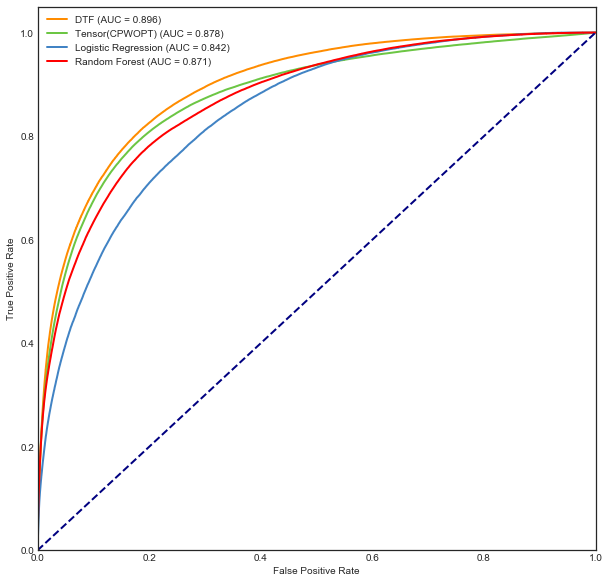

In [12]:
for i in range(4):
    cal_fpr_tpr(methods[i])
draw_ave_auc()

<Figure size 640x480 with 0 Axes>

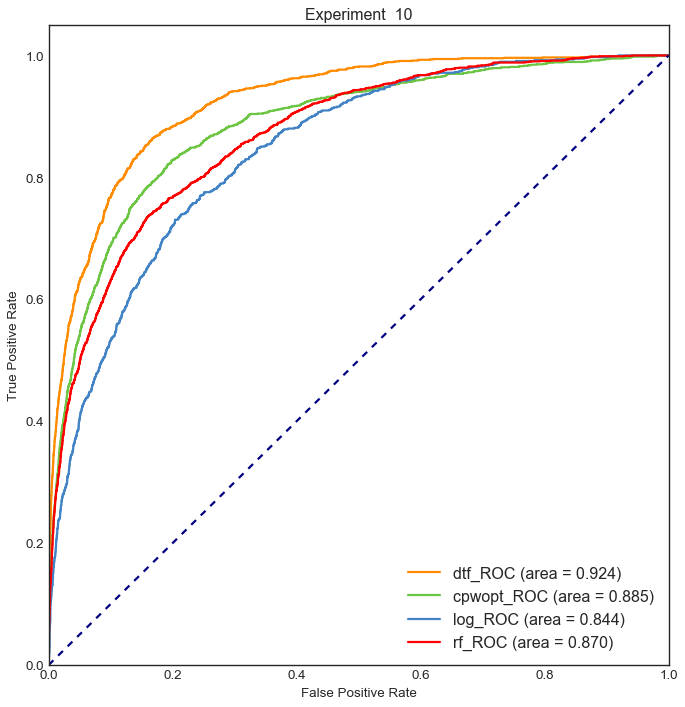

In [75]:
auc_curve(10)

# draw average auc and acc for each cell line

In [12]:
all_auc_ave = []
for i in range(39):
    tmp_sum_auc = 0
    for k in range(100):
        true = read_txt(k+1,'test_labels')[468*i:468*(i+1)]
        true = true.astype(np.int16)
        score = read_txt(k+1,'dnn_test_pre')[468*i:468*(i+1)]
        fpr,tpr,thresholds = roc_curve(true,score)
        tmp_sum_auc += auc(fpr,tpr)
    all_auc_ave.append(tmp_sum_auc/100)
save_txt(1,'all_auc_ave',all_auc_ave,1)

In [ ]:
def ret_index(num):
    z = num // (38*38)
    res = num % (38*38)
    y = res // 38
    x = res % 38
    return x,y,z

def ret_ori_name(x,y,z):
    return drug_names[x],drug_names[]

<Figure size 576x396 with 0 Axes>

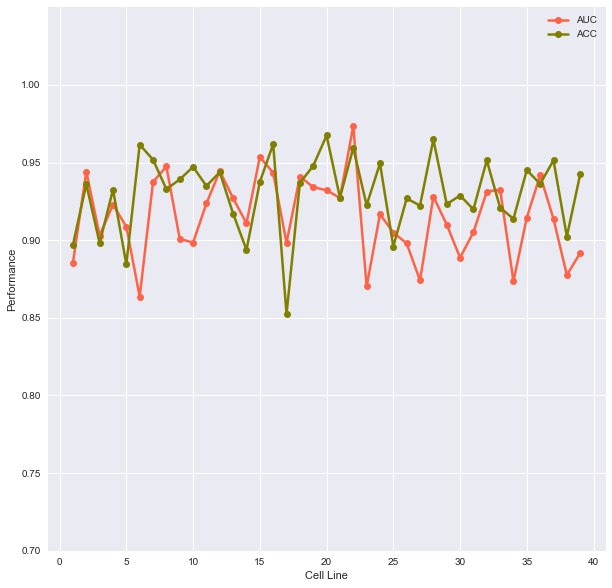

In [47]:
cell_line = list(range(1,40))
all_auc_ave = read_txt(1,'all_auc_ave',1)
#all_auc_ave_2 = read_txt(1,'all_auc_ave_v2',1)
all_acc_ave = read_txt(1,'all_acc_ave',1)
plt.figure()
lw = 2.5
plt.style.use('seaborn')
plt.figure(figsize=(10,10))
plt.plot(cell_line, all_auc_ave, color='tomato',
             lw=lw, label='AUC',marker='o' ) 
plt.plot(cell_line, all_acc_ave, lw = lw,
         color = 'olive',label = 'ACC', marker = 'o')
plt.ylim([0.0, 1.05])
font = {'family' : 'monospace',
'weight' : 'bold',
'size'   : 30,
}
font2 = {'family': 'Times New Roman',
         'weight': 'normal', 
         'size': 20}
plt.xlabel('Cell Line')
plt.yticks(np.linspace(0,1,21))
plt.ylabel('Performance')
plt.legend(loc="best")
plt.ylim([0.7, 1.05])
#plt.legend(loc="best",prop = font)
#plt.savefig('test_2.eps',dpi=1000,format='eps')
plt.grid(color = 'w')
plt.savefig('/Users/apple/Desktop/tensor_pro/figures/ave_roc_for_all_v1.eps',dpi=1000,format='eps'
        ,bbox_inches = 'tight')
plt.show()

# calculate average auc, standard deviation and 95% confidence interval

In [63]:
for i in range(4):
    tmp_sum = 0
    tmp_list = []
    for k in range(100):
        to_add = read_txt(k+1,methods[i]+'_auc')
        tmp_sum += to_add
        tmp_list.append(to_add)
    print(methods[i])
    print('ave_auc')
    print(round(tmp_sum/100,6))
    print('sd')
    print(round(np.std(tmp_list),6))
    print('ci')
    print(round(np.percentile(tmp_list,2.5),6))
    print(round(np.percentile(tmp_list,97.5),6))

dtf
ave_auc
0.924369
sd
0.00587
ci
0.910947
0.933339
cpwopt
ave_auc
0.877733
sd
0.006249
ci
0.866254
0.889531
log
ave_auc
0.842746
sd
0.005575
ci
0.832784
0.852561
rf
ave_auc
0.871442
sd
0.006125
ci
0.860741
0.883001
